In [2]:
from flask import Flask, request, jsonify
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import requests
from urllib.request import urlopen
import timm
import io
from io import BytesIO

## Flask API Guide

### How the Following Code Works
##### First, the Model is loaded and fitted using the trained weights 
##### Then, the following functions are used to put the model into use:

- ##### The model takes in an image path
  
- ##### After ensuring an acceptable file is sent, it is then read and sent to the image_transformation function
    - This function takes the contents of the image file and wraps it in a steam, allowing you to treat it like a file object
    - Then, it changes the image to RGBA, resizes it, transforms it to a tensor, and normalizes it before adding a batch dimension and placing it in the variable tensor
    - These transformations ensure the image sent is in the same format as the images the model was trained on
          
- ##### The variable tensor is then sent to the get_prediction function
    - This sends the tensor to the model
    - Selects the output class with the highest probability
    - Matches the output class with its label name and finally returns the label name.
      
- ##### Then, the label name is put into a dictionary, which is sent to the user 
###

### Usage Instructions:
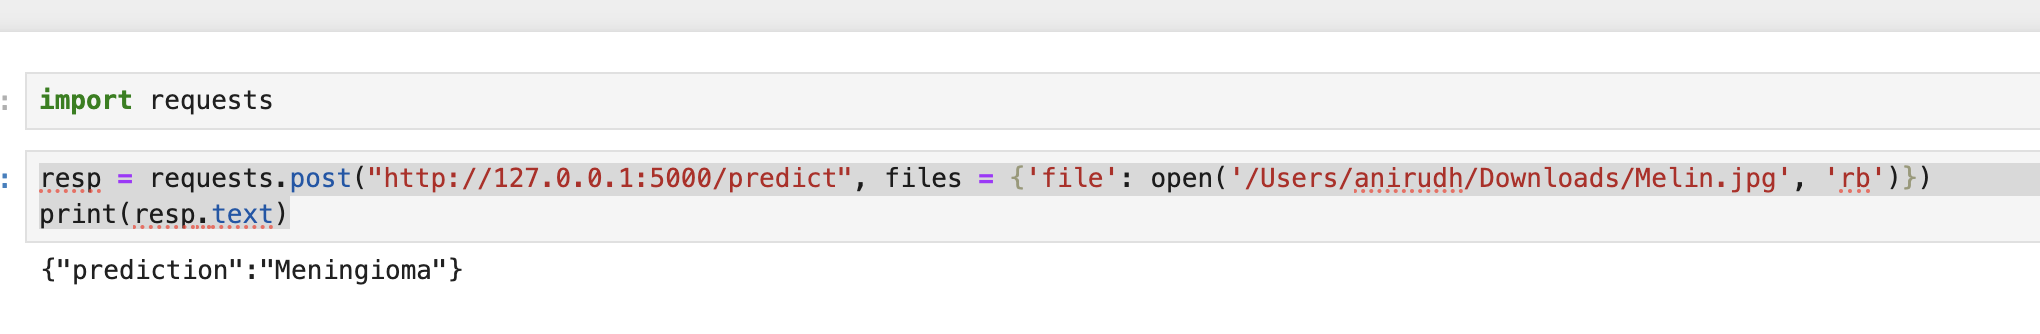
Import requests
* Create a response variable and send a post request to the host: "http://127.0.0.1:5000/predict"
    * In this case, the response variable is "resp"<p/>

* Inside the post request, also send a file dictionary in the following format: files = {'file': open(image_path, 'rb')}
* Print the response text

In [ ]:
app = Flask(__name__)

model = timm.create_model('densenet121.ra_in1k', pretrained=False)
model.features[0] = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
model.classifier = nn.Linear(1024, 6)
PATH = "/users/anirudh/MedicalProject/MedicalClassification.pth"
model.load_state_dict(torch.load(PATH))
model.eval()

def image_transformation(image_bytes):
        image_data = BytesIO(image_bytes)
        image_data.seek(0)
        img = Image.open(image_data)
        
        transform = transforms.Compose( 
                [
                    transforms.Lambda(lambda img: img.convert("RGBA")),
                    transforms.Resize((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean = [-5.0247e-05, -2.3672e-05,  2.9741e-05,  3.6599e+00], std=[0.9986, 0.9986, 0.9987, 0.0011])                 
                ]
            )
        transformed_img = transform(img).unsqueeze(0)
        return transformed_img


def get_prediction(image_tensor):
    out = model(image_tensor)
    predictions = torch.argmax(out, axis =1)
    Label_dict = {0:"Not Fractured", 1: "Fractured Bone", 2: "No Tumor", 3:"Glioma", 4:"Meningioma", 5:"Pituitary"}
    Final_prediction = Label_dict[predictions.item()]
    return Final_prediction

    


ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg'}
def allowed_file(filename):
    return '.' in filename and filename.rsplit('.',1)[1].lower() in ALLOWED_EXTENSIONS
    

@app.route('/predict', methods = ['POST'])
def predict():
    if request.method == 'POST':
        file = request.files.get('file')
        if file is None or file.filename == "":
            return jsonify({'Error': 'No File'})
        if not allowed_file(file.filename):
            return jsonify({'Error': 'File Format Not Supported'})
        try:
            img_bytes = file.read()
            tensor = image_transformation(img_bytes)
            prediction = get_prediction(tensor)
            data = {'prediction':str(prediction)}
            return jsonify(data)


        except:
            return jsonify({'Error': 'Error During Prediction'})

    return jsonify({'result': 1})

if __name__ == "__main__":
    app.run(port = 5000)